# Простой пример парсинга и аналитики данных по игре World of Tanks

В этом небольшом примере, я хочу показать, как парсить данные с сайтов и как дальше использовать их для анализа. Для этого я спарсил таблицу рейтингов кланов из игры [World of Tanks](https://ru.wargaming.net/ru/games/wot) и посмотрел, как рейтинг клана может коррелировать с другими данными.

![](WoT_logo.png)

### 1. Парсинг данных

In [1]:
import numpy as np
import pandas as pd
from scrapy.selector import Selector
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(rc={'figure.figsize':(20, 5)})

Данные на [страницу](https://ru.wargaming.net/clans/wot/leaderboards/#ratingssearch&offset=0&limit=25&order=-cr) подгружаются через javascript виджеты, из-за этого средствами [scrapy](https://scrapy.org/) получится только скачать html без данных, чтобы не усложнять пример (в таком случае можно например использовать [selenium](https://www.selenium.dev/)) я просто сохранил страницу из браузера и использовал `scrpy Selector` для парсинга.

In [2]:
#https://ru.wargaming.net/clans/wot/leaderboards/#ratingssearch&offset=0&limit=25&order=-cr
with open('Рейтинги _ Wargaming.net.html', 'r') as f:
    html_text = f.read()
    
selector = Selector(text=html_text)

Чтобы понять как работать с `xpath` лучше всего посмотреть что-нибудь на [youtube.com](https://www.youtube.com/results?search_query=xpath), благо информации по этой теме много. В коде ниже я спарсил первые три строки отдельно, т.к. они сформированы немного по другому (см. [сайт](https://ru.wargaming.net/clans/wot/leaderboards/#ratingssearch&offset=0&limit=25&order=-cr)), далее я распарсил каждые данные отдельно, причём в данном случае удобнее было парсить массив `text` с конца, так как в начале строка может иметь разное количество столбцов (с точки зрения кода), например у некоторых логотипов есть цифра, показывающая рост, у других нет. 

In [3]:
df = pd.DataFrame()

# первые три строки + остальные строчки
table = selector.xpath('//div[@class="js-widget-content"]/div[2]/div[2]/div') + selector.xpath('//div[@class="js-widget-content"]/div[2]/div[4]/div')

for row in table:
    text = row.xpath('*//text()').extract()
    clan = text[-10] 
    cr = int(text[-7].replace(' ',''))
    wpr = int(text[-6].replace(' ','')) 
    abd = float(text[-5].replace(',', '.')) 
    avl_10 = int(text[-4]) 
    fsh = int(text[-3].replace(' ','')) 
    wgm = int(text[-2].replace(' ','')) 
    wsh = int(text[-1].replace(' ',''))   

    df = df.append({'Clan' : clan,      # клан
                    'CR' : cr,          # рейтинг клана
                    'wPR' : wpr,        # Средневзвешенный личный рейтинг игроков по максимальному количеству игроков в клане (100)
                    'aB_D' : abd,       # Среднее количество боёв в день во всех режимах на одного игрока
                    'aVL10' : avl_10,   # Среднее количество техники, участвовавшей в бою, в любом режиме на одного игрока
                    'fSH' : fsh,        # Составляющая рейтинга Укрепрайона
                    'wGM' : wgm,        # Средневзвешенный рейтинг Эло на Глобальной карте
                    'wSH' : wsh},       # Средневзвешенный Рейтинг Эло в Укрепрайоне
                    ignore_index=True)

Полученные данные я сохранил в датафрейме `df`, проверить правильность парсинга можно по количеству строк таблицы на [странице](https://ru.wargaming.net/clans/wot/leaderboards/#ratingssearch&offset=0&limit=25&order=-cr) их ровно 25, также можно посмотреть на примере первых 5 строк правильность парсинга.

In [4]:
print('Кол-во строк в таблице:', len(df))

Кол-во строк в таблице: 25


In [5]:
df.head()

,CR,Clan,aB_D,aVL10,fSH,wGM,wPR,wSH
0,15486.0,[CM-1],18.20,34.0,4083.0,2253.0,10325.0,2294.0
1,15148.0,[R-BOY],18.86,37.0,3745.0,1943.0,10267.0,2066.0
2,15041.0,[CYS],17.47,32.0,3649.0,2300.0,10251.0,1857.0
3,14984.0,[I-YAN],16.85,28.0,4080.0,2468.0,8992.0,2290.0
4,14952.0,[YETT1],17.41,29.0,4222.0,2159.0,8387.0,2474.0


### 2. Аналитика данных

Из полученных данных можно построить графики, из которых можно попробовать получить какие-то закономерности, либо синтезировать новые данные. На графике ниже я построил график роста рейтинга клана в зависимости от места.

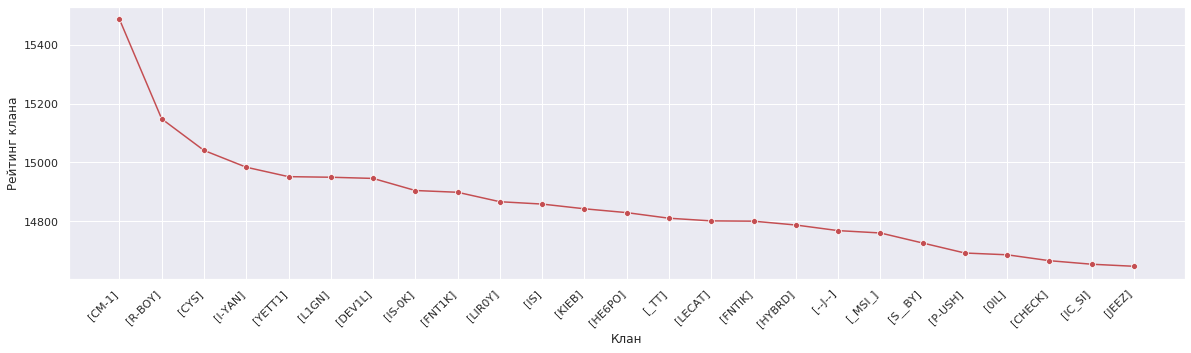

In [6]:
plt.xticks(rotation=45, ha="right")
ax = sns.lineplot(x='Clan', y='CR', data=df, marker='o', color='r', sort=False)
ax.set(xlabel='Клан', ylabel='Рейтинг клана')
ax.set(xticks=df['Clan'].values);

На двух графиках ниже я наложил график роста рейтинга клана на другие данные таблицы для анализа их корреляции. Здесь я пробую ответить на вопрос, а какие данные более важные для получения выского рейтинга?

In [7]:
# функция накладывает графики друг на друга
def draw_corr(df, y1, y1_label, y2='CR', y2_label='Рейтинг клана'):
    fig, ax = plt.subplots()
    plt.xticks(rotation=45, ha="right")
    sns.lineplot(x='Clan', y=y1, data=df, marker='o', color='b', label=y1_label, sort=False)
    ax.set(xlabel='Клан', ylabel=y1_label)
    plt.legend(bbox_to_anchor=(0.01, 0.95), loc='upper left')
    ax2 = ax.twinx()
    sns.lineplot(x='Clan', y=y2, data=df, marker='o', color='r', label=y2_label, sort=False)
    ax2.set(ylabel=y2_label)
    plt.legend(bbox_to_anchor=(0.01, 0.85), loc='upper left');   

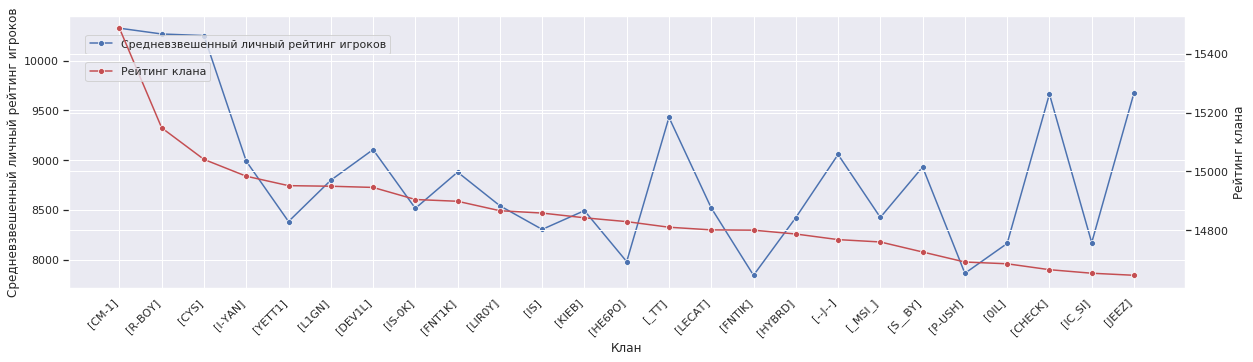

In [8]:
draw_corr(df, 'wPR', 'Средневзвешенный личный рейтинг игроков')

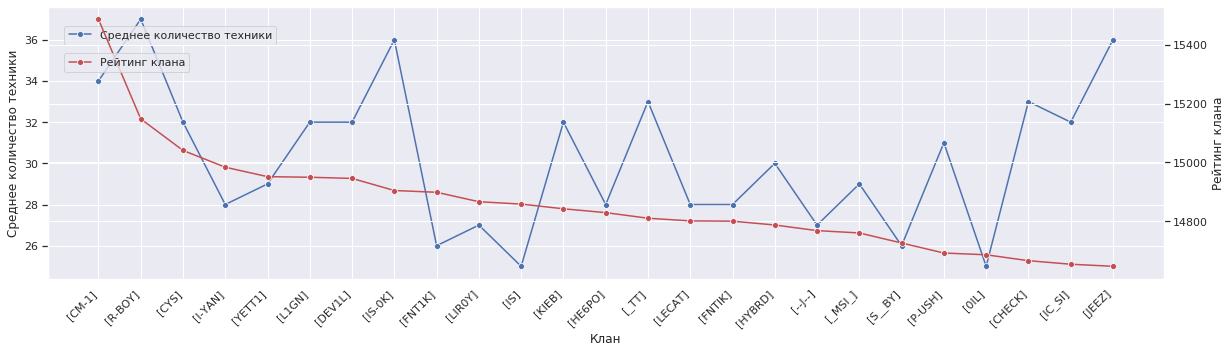

In [9]:
draw_corr(df, 'aVL10', 'Среднее количество техники')

### 3. Выводы

Данная статья специально написана просто, для того, чтобы показать, что в парсинге и аналитике данных ничего сложного нет. Из полученных данных можно составить больше графиков корреляции, построить гистограммы, если это будет нжуно, сделать какие-то прогнозы и т.д.